In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

sys.path.append('/srv/cvmlp-lab/scratch/anarayanan68/mint/')

In [4]:
from mint.core import inputs
from mint.core import model_builder
from mint.ctl import single_task_evaluator
from mint.utils import config_util
from third_party.tf_models import orbit
import tensorflow as tf

import ipywidgets as widgets
from IPython.display import display

import pprint
import hashlib
import pickle
import numpy as np
import copy
import vedo
from scipy.spatial.transform import Rotation as R
from smplx import SMPL
import time
import torch

embedWindow(verbose=True): could not load ipyvtklink try:
> pip install ipyvtklink


In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [6]:
config_path = '/coc/scratch/anarayanan68/mint/configs/embedding_layer_pilot.config'
name_enc_config_path = '/srv/cvmlp-lab/scratch/anarayanan68/mint/configs/embedding_layer_pilot-name_enc.yml'
enc_pkl_path = '/srv/cvmlp-lab/scratch/anarayanan68/mint/_expts/embedding_layer_pilot__5/enc_data.pkl'

checkpoint_dir = '/srv/cvmlp-lab/scratch/anarayanan68/mint/_expts/embedding_layer_pilot__5/checkpoints/'

In [9]:
configs = config_util.get_configs_from_pipeline_file(config_path)
model_config = configs['model']
eval_config = configs['eval_config']
eval_dataset_config = configs['eval_dataset']

In [8]:
name_enc_config_yaml = config_util.read_yaml_config(name_enc_config_path)

In [10]:
# Model build & restore

model = model_builder.build(model_config, is_training=False,
    name_encoder_config_yaml=name_enc_config_yaml, dataset_config=eval_dataset_config)

checkpoint_manager=tf.train.CheckpointManager(
    tf.train.Checkpoint(model=model),
    directory=checkpoint_dir,
    max_to_keep=None)

checkpoint_path = checkpoint_manager.restore_or_initialize()

if checkpoint_path is not None:
    print(f"restored model from {checkpoint_path}.")
else:
    print("initialized model.")

restored model from /srv/cvmlp-lab/scratch/anarayanan68/mint/_expts/embedding_layer_pilot__5/checkpoints/ckpt-9999.


In [17]:
all_embeddings = model.name_enc_stage(np.eye(20)).numpy()
all_embeddings_flat = all_embeddings.reshape((20,-1))

In [18]:
tsne2 = TSNE(n_components=2, init='pca')
tsne3 = TSNE(n_components=3, init='pca')

emb_tsne2 = tsne2.fit_transform(all_embeddings_flat)
emb_tsne3 = tsne3.fit_transform(all_embeddings_flat)

In [20]:
emb_tsne2.shape, emb_tsne3.shape

((20, 2), (20, 3))

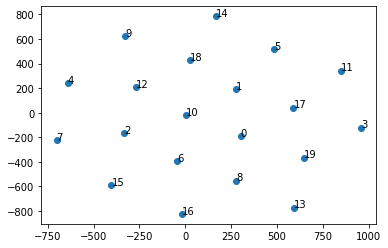

In [26]:
labels = np.arange(20)

plt.scatter(emb_tsne2[:,0], emb_tsne2[:,1])
for i, l in enumerate(labels):
    plt.annotate(l, (emb_tsne2[i,0], emb_tsne2[i,1]))

plt.show()

In [27]:
checkpoint_manager.checkpoints

['/srv/cvmlp-lab/scratch/anarayanan68/mint/_expts/embedding_layer_pilot__5/checkpoints/ckpt-6001',
 '/srv/cvmlp-lab/scratch/anarayanan68/mint/_expts/embedding_layer_pilot__5/checkpoints/ckpt-7001',
 '/srv/cvmlp-lab/scratch/anarayanan68/mint/_expts/embedding_layer_pilot__5/checkpoints/ckpt-8001',
 '/srv/cvmlp-lab/scratch/anarayanan68/mint/_expts/embedding_layer_pilot__5/checkpoints/ckpt-9001',
 '/srv/cvmlp-lab/scratch/anarayanan68/mint/_expts/embedding_layer_pilot__5/checkpoints/ckpt-9999']

In [28]:
ckpt = tf.train.Checkpoint(model)
ckpt.restore(checkpoint_manager.checkpoints[0])


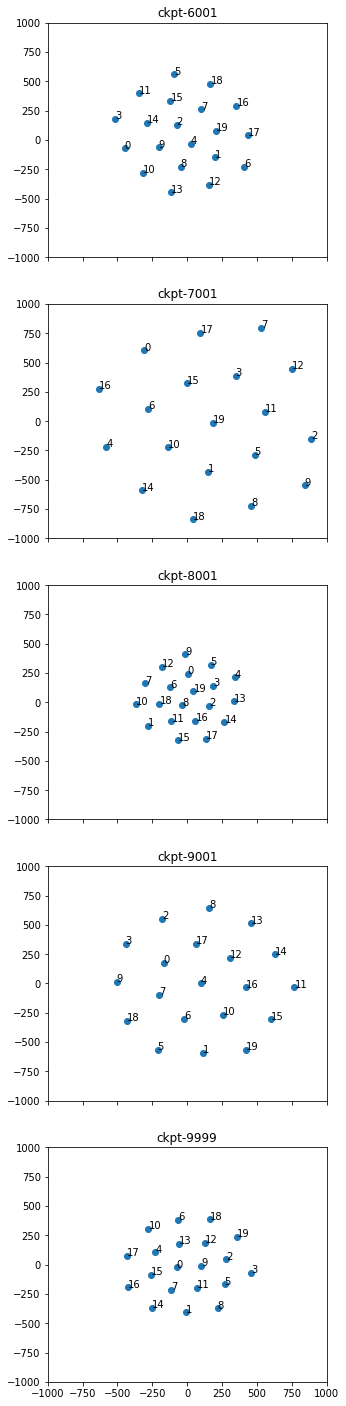

In [36]:
# 2D viz

labels = np.arange(20)

n = len(checkpoint_manager.checkpoints)
fig, axs = plt.subplots(n, 1, sharex=True, figsize=(5,5*n))

for cpath, ax in zip(checkpoint_manager.checkpoints, axs):
    ckpt = tf.train.Checkpoint(model)
    ckpt.restore(cpath)

    all_embeddings = model.name_enc_stage(np.eye(20)).numpy()
    all_embeddings_flat = all_embeddings.reshape((20,-1))

    emb_tsne2 = tsne2.fit_transform(all_embeddings_flat)

    ax.set_title(os.path.basename(cpath))
    ax.set_xlim((-1000,1000))
    ax.set_ylim((-1000,1000))
    ax.scatter(emb_tsne2[:,0], emb_tsne2[:,1])
    for i, l in enumerate(labels):
        ax.annotate(l, (emb_tsne2[i,0], emb_tsne2[i,1]))

plt.show()